# Compute ell-cuts based on a $k_{max}$

In [28]:
import yaml

import numpy as np

import sacc
import pyccl as ccl

%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
sacc_file = "../../gaussian-sims-srd-sample/data-vector/twopoint_theory_fourier_w_full_cov.sacc"

sacc_data = sacc.Sacc.load_fits(sacc_file)


### Create CCL tracers for all the tracers in the sacc file

In [30]:
ccl_tracers = {}

ccl_cosmo = ccl.CosmologyVanillaLCDM()

for data_type in sacc_data.get_data_types():
    print(data_type)
    tracers = sacc_data.get_tracer_combinations(data_type)
    for tracer_names in tracers:
        for tracer_name in tracer_names:
            if tracer_name in ccl_tracers:
                continue

            tracer = sacc_data.get_tracer(tracer_name)
            if not isinstance(tracer, sacc.tracers.NZTracer):
                raise ValueError(f"Tracer {tracer_name} not a NZTracer!")
            
            if "source" in tracer.name:
                ccl_tracers[tracer_name] = ccl.WeakLensingTracer(
                                                ccl_cosmo,
                                                dndz=(tracer.z, tracer.nz))
            elif "lens" in tracer.name:
                ccl_tracers[tracer_name] = ccl.NumberCountsTracer(
                                                ccl_cosmo, has_rsd=False,
                                                dndz=(tracer.z, tracer.nz),
                                                bias=(tracer.z, np.ones_like(tracer.z)))
            else:
                raise ValueError(f"Unknown tracer type {tracer_name}!")

galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee


### Compute the scale cuts for all tracer pairs in the sacc file

In [ ]:
k_max = 0.5 # Mpc^-1

kernel_quantiles = [0.1, 0.5]

chi_cuts = {}
ell_max = {}

chi = np.linspace(0, ccl.comoving_radial_distance(ccl_cosmo, a=1/(1+7)), 7000)

print(f"{'':<20} {'peak':>15} {'0.1 quant.':>15} {'0.5 quant.':>15}")
for data_type in sacc_data.get_data_types():
    print()
    print(data_type)
    tracer_pairs = sacc_data.get_tracer_combinations(data_type)
    for tracer_names in tracer_pairs:
        tracer_1, tracer_2 = ccl_tracers[tracer_names[0]], ccl_tracers[tracer_names[1]]
        w_1, w_2 = tracer_1.get_kernel(chi), tracer_2.get_kernel(chi)

        w = w_1 * w_2
        w /= np.sum(w)
        if np.allclose(w, 0) or np.any(~np.isfinite(w)):
            print(f"{'-'.join(tracer_names):15} No overlap")
            ell_max[tracer_names] = {"peak": None, **{f"q_{q}": None for q in kernel_quantiles}}
            continue

        chi_kernel_peak = chi[np.argmax(w)]

        kernel_quantiles_idx = np.searchsorted(np.cumsum(w), kernel_quantiles)

        ell_max_peak = k_max * chi_kernel_peak
        ell_max_quantiles = k_max * chi[kernel_quantiles_idx]

        chi_cuts[tracer_names] = {"peak": chi_kernel_peak, **{f"q_{q}": c for q, c in zip(kernel_quantiles, chi[kernel_quantiles_idx])}}
        ell_max[tracer_names] = {"peak": float(ell_max_peak), **{f"q_{q}": float(e) for q, e in zip(kernel_quantiles, ell_max_quantiles)}}

        print(f"{'-'.join(tracer_names):<20} {ell_max_peak:15.0f} " + " ".join([f"{ell:15.0f}" for ell in ell_max_quantiles]))



In [32]:
cut_type = "peak"
with open(f"../likelihood/scale_cuts_kmax-{k_max}_{cut_type}.yaml", "w") as f:
    yaml.dump({"-".join(k): v[cut_type] for k, v in ell_max.items()}, f)

## Compute scale cuts based on each individual kernel

In [33]:
k_max = 0.5

kernel_quantiles = [0.1, 0.5]

chi_cuts = {}
ell_max = {}

for tracer_name, tracer in ccl_tracers.items():
    w, chi = tracer.get_kernel(chi=None)
    w, chi = w[0], chi[0]

    chi_kernel_peak = chi[np.argmax(w)]

    kernel_quantiles_idx = np.searchsorted(np.cumsum(w)/np.sum(w), kernel_quantiles)

    ell_max_peak = k_max * chi_kernel_peak
    ell_max_quantiles = k_max * chi[kernel_quantiles_idx]

    chi_cuts[tracer_name] = {"peak": chi_kernel_peak, **{f"q_{q}": c for q, c in zip(kernel_quantiles, chi[kernel_quantiles_idx])}}
    ell_max[tracer_name] = {"peak": ell_max_peak, **{f"q_{q}": e for q, e in zip(kernel_quantiles, ell_max_quantiles)}}

    print(f"{tracer_name:10} {chi_kernel_peak:7.1f} {ell_max_peak:7.0f} " + " ".join([f"{ell:7.0f}" for ell in ell_max_quantiles]))



lens_0      1382.7     691     468     652
lens_1      2025.8    1013     828     994
lens_2      2604.0    1302    1155    1310
lens_3      3172.2    1586    1450    1593
lens_4      3687.5    1844    1712    1846
source_0     592.4     296     121     353
source_1    1037.8     519     239     573
source_2    1457.3     729     296     729
source_3    1946.2     973     409     973
source_4    2732.4    1366     677    1523


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

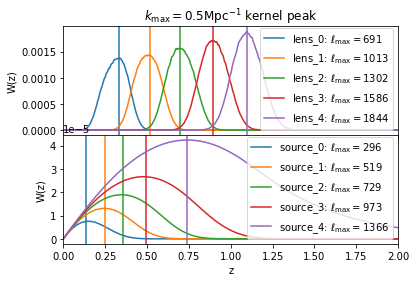

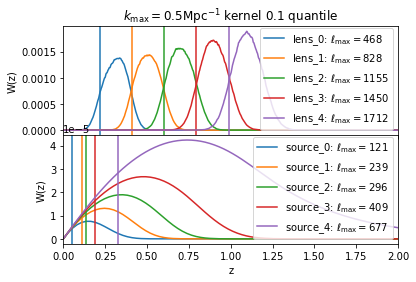

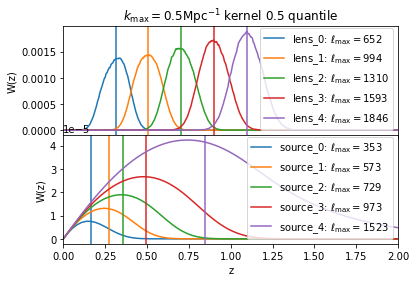

In [34]:

for cut_name, cut_type in zip(["kernel peak", "kernel 0.1 quantile", "kernel 0.5 quantile"], ["peak", "q_0.1", "q_0.5"]):
    fig, ax = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0)
    lens_idx = 0
    source_idx = 0

    for tracer_name, tracer in ccl_tracers.items():
        w, chi = tracer.get_kernel(chi=None)
        w, chi = w[0], chi[0]

        z = 1/ccl.scale_factor_of_chi(ccl_cosmo, chi) - 1
        if "lens" in tracer_name:
            ax_idx = 0
            c = f"C{lens_idx}"
            lens_idx += 1
        else:
            ax_idx = 1
            c = f"C{source_idx}"
            source_idx += 1
        
        ax[ax_idx].plot(z, w, c=c, label=f"{tracer_name}: $\\ell_\\mathrm{{max}} = {ell_max[tracer_name][cut_type]:.0f}$")
        ax[ax_idx].axvline(1/ccl.scale_factor_of_chi(ccl_cosmo, chi_cuts[tracer_name][cut_type]) - 1, c=c)
        
        ax[0].set_xlim(left=0, right=2)

        ax[0].legend()
        ax[1].legend()

        ax[0].set_ylabel("W(z)")
        ax[1].set_ylabel("W(z)")

        ax[1].set_xlabel("z")

        ax[0].set_title("$k_\\mathrm{max} = 0.5 \mathrm{Mpc}^{-1}$ "+ cut_name)

